# Open Weather Map Data Check
#### Joe Nguyen | 04Feb2020

- Sense check weather data
- Shen notes:
According to our agreement with the vendor, the historical weather data should start from 1 Jan 2012 up to today, covering 986 Australian postcodes that we provided them with. Please see attached the list of the 986 postcodes that we provided.

The checks we'd like to perform include:
- Are all 986 postcodes covered in the data?
- Did the data start on 1 Jan 2012 for each postcode?
- Did the data continue up until today (day of extraction)? Any missing period of time for each postcode?
- Number of rows is equal for each postcode?
- Hourly frequency for each postcode?
- Any unreasonable lat/lon? (e.g. lat being positive is impossible within Australia)
- Any unreasonable feature values? (e.g. temperature > 60)
- Any missing features for certain postcodes?
- Is data type consistent for each data feature?
- Any other checks that you did last time.

In [185]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [76]:
import os, sys, importlib
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')
import UDF_Utils as utl
import UDF_Transformation as tfm
import UDF_Visualisation as viz
sys.path.insert(0, '/home/jovyan/a01_repos/wx_tools')
import Wx_Utils as wxu

importlib.reload(sys.modules['UDF_Utils'])
importlib.reload(sys.modules['UDF_Transformation'])

<module 'UDF_Transformation' from '/home/jovyan/a01_repos/joe_utils/UDF_Transformation.py'>

## Load Data

In [2]:
url_tar = 'http://history.openweathermap.org/storage/8b62ce035425e234ad0786b1d87b0820.tar.gz'
# stream = urllib.request.urlopen(url_tar)
# file_tar = tarfile.open(fileobj=stream, mode="r|gz")
# file_tar = '8b62ce035425e234ad0786b1d87b0820.tar.gz'
# file_tar = 'grades.tar.gz'
path_prj = '/home/jovyan/a02_projects/a04_weather'
path_data = f'{path_prj}/a01_data'
# path_tar = f'{path_data}/{file_tar}'

tStart = utl.Timer()
rawData = utl.Read_Tarfile_Csv(url_tarfile=url_tar)
# rawData = utl.Read_Tarfile_Csv(path_tarfile=path_tar)
utl.Timer(tStart)
print(rawData.shape)
rawData.head(2)
# rawData.dtypes


>> Time taken: 0 hours 6 minutes and 36.28 seconds.
(69880637, 34)


dt                         dt_iso  timezone  post_code state_code  \
0  1325376000  2012-01-01 00:00:00 +0000 UTC     39600       2170        NSW   
1  1325379600  2012-01-01 01:00:00 +0000 UTC     39600       2170        NSW   

       lat      lon    temp  feels_like  temp_min  ...  snow_3h  snow_6h  \
0 -33.9197  150.959  298.24      296.58    297.15  ...      NaN      NaN   
1 -33.9197  150.959  298.54      297.87    297.95  ...      NaN      NaN   

   snow_12h  snow_24h  snow_today  clouds_all  weather_id  weather_main  \
0       NaN       NaN         NaN           0         800         Clear   
1       NaN       NaN         NaN           4         800         Clear   

   weather_description  weather_icon  
0         sky is clear           01d  
1         sky is clear           01d  

[2 rows x 34 columns]

In [3]:
# AU postcodes
path_postcode = f'{path_data}/AU_postcode_986.csv'
postcodeLs = pd.read_csv(path_postcode)
print(postcodeLs.shape)
postcodeLs.head(2)

(986, 2)


postcode state
0      4171   QLD
1      3171   VIC

## Summary Stats
#### Are all 986 postcodes covered in the data?

In [7]:
postcodeUnq = rawData['post_code'].unique()
print(len(postcodeUnq)) # 986
print(postcodeUnq.min()) # 800
print(postcodeUnq.max()) # 7330
postcodeUnq[:2]

986
800
7330


array([2170, 2211])

In [5]:
print(rawData['post_code'].dtypes)
rawData.loc[rawData['post_code'] == 800,:].head(2)

int64


dt                         dt_iso  timezone  post_code  \
4039911  1325376000  2012-01-01 00:00:00 +0000 UTC     34200        800   
4039912  1325379600  2012-01-01 01:00:00 +0000 UTC     34200        800   

        state_code      lat       lon    temp  feels_like  temp_min  ...  \
4039911         NT -12.4611  130.8418  304.01      305.84    303.05  ...   
4039912         NT -12.4611  130.8418  305.90      308.98    305.15  ...   

         snow_3h  snow_6h  snow_12h  snow_24h  snow_today  clouds_all  \
4039911      NaN      NaN       NaN       NaN         NaN          75   
4039912      NaN      NaN       NaN       NaN         NaN          75   

         weather_id  weather_main  weather_description  weather_icon  
4039911         803        Clouds        broken clouds           04d  
4039912         803        Clouds        broken clouds           04d  

[2 rows x 34 columns]

In [8]:
# Match postcodes to AU postcodes file
postcodeLs['postcode'].isin(postcodeUnq).sum()

986

#### Did the data start on 1 Jan 2012 for each postcode?

In [9]:
postcodeDates = rawData.groupby('post_code').agg({'dt_iso': ['min', 'max']})
postcodeDates.head()

dt_iso                               
                                     min                            max
post_code                                                              
800        2012-01-01 00:00:00 +0000 UTC  2020-01-26 23:00:00 +0000 UTC
810        2012-01-01 00:00:00 +0000 UTC  2020-01-26 23:00:00 +0000 UTC
812        2012-01-01 00:00:00 +0000 UTC  2020-01-26 23:00:00 +0000 UTC
820        2012-01-01 00:00:00 +0000 UTC  2020-01-26 23:00:00 +0000 UTC
829        2012-01-01 00:00:00 +0000 UTC  2020-01-26 23:00:00 +0000 UTC

In [10]:
print(postcodeDates.columns)
print(postcodeDates[('dt_iso', 'min')].min())
print(postcodeDates[('dt_iso', 'max')].max())

MultiIndex([('dt_iso', 'min'),
            ('dt_iso', 'max')],
           )
2012-01-01 00:00:00 +0000 UTC
2020-01-26 23:00:00 +0000 UTC


#### Did the data continue up until today (day of extraction)? Any missing period of time for each postcode?

In [11]:
# Take date difference (between rows) by postcode
dateSorted = rawData[['post_code', 'dt', 'dt_iso']].sort_values(by=['post_code', 'dt'])
dateSorted.head()

post_code          dt                         dt_iso
21331042        800  1325376000  2012-01-01 00:00:00 +0000 UTC
21331043        800  1325379600  2012-01-01 01:00:00 +0000 UTC
21331044        800  1325383200  2012-01-01 02:00:00 +0000 UTC
21331045        800  1325386800  2012-01-01 03:00:00 +0000 UTC
21331046        800  1325390400  2012-01-01 04:00:00 +0000 UTC

In [12]:
dateSortedDiff = dateSorted.groupby(['post_code'])['dt'].diff().fillna(0)

In [13]:
dateSortedDiff = dateSorted.merge(
    dateSortedDiff.rename('dt_diff')
    ,left_index=True
    ,right_index=True
)

In [14]:
dateSortedDiff.head(3)

post_code          dt                         dt_iso  dt_diff
21331042        800  1325376000  2012-01-01 00:00:00 +0000 UTC      0.0
21331043        800  1325379600  2012-01-01 01:00:00 +0000 UTC   3600.0
21331044        800  1325383200  2012-01-01 02:00:00 +0000 UTC   3600.0

In [15]:
postcodeDateDiff = dateSortedDiff.groupby('post_code').agg({'dt_diff': ['min', 'max']})
postcodeDateDiff.head(3)

dt_diff        
              min     max
post_code                
800           0.0  3600.0
810           0.0  3600.0
812           0.0  3600.0

In [16]:
print(len(postcodeDateDiff.index.unique()))
print(postcodeDateDiff[('dt_diff', 'min')].min())
print(postcodeDateDiff[('dt_diff', 'max')].max())
# All 986 postcodes have a maximum dt period of 3600 seconds, i.e. no missing records

986
0.0
3600.0


#### Number of rows is equal for each postcode?

In [15]:
postcodeCnt = rawData['post_code'].value_counts()
print(postcodeCnt.describe().round(1))

count      986.0
mean     70881.0
std        129.2
min      70760.0
25%      70768.0
50%      70868.5
75%      70945.8
max      71839.0
Name: post_code, dtype: float64


In [17]:
# Fixed file (2020-02-07)
postcodeCnt = rawData['post_code'].value_counts()
print(postcodeCnt.describe().round(1))

count      986.0
mean     70872.9
std        129.1
min      70752.0
25%      70760.0
50%      70860.0
75%      70937.8
max      71829.0
Name: post_code, dtype: float64


In [16]:
postcodeCnt[postcodeCnt == 71839]

3038    71839
Name: post_code, dtype: int64

In [17]:
postcodeCnt[postcodeCnt == 70760]

3500    70760
3465    70760
4715    70760
4716    70760
3450    70760
        ...  
2357    70760
2350    70760
2340    70760
2337    70760
7330    70760
Name: post_code, Length: 195, dtype: int64

In [18]:
rawData[rawData['post_code'] == 3500].head(3)

dt                         dt_iso  timezone  post_code  \
5811303  1325376000  2012-01-01 00:00:00 +0000 UTC     39600       3500   
5811304  1325379600  2012-01-01 01:00:00 +0000 UTC     39600       3500   
5811305  1325383200  2012-01-01 02:00:00 +0000 UTC     39600       3500   

        state_code      lat       lon    temp  feels_like  temp_min  ...  \
5811303        VIC -34.1958  142.1464  305.36      302.49    305.36  ...   
5811304        VIC -34.1958  142.1464  310.24      307.07    310.24  ...   
5811305        VIC -34.1958  142.1464  310.29      307.82    310.29  ...   

         snow_3h  snow_6h  snow_12h  snow_24h  snow_today  clouds_all  \
5811303      NaN      NaN       NaN       NaN         NaN           0   
5811304      NaN      NaN       NaN       NaN         NaN           0   
5811305      NaN      NaN       NaN       NaN         NaN           0   

         weather_id  weather_main  weather_description  weather_icon  
5811303         800         Clear         sky is clear           01d  
5811304         800         Clear         sky is clear           01d  
5811305         800         Clear         sky is clear           01d  

[3 rows x 34 columns]

In [19]:
unqData = rawData.drop_duplicates()
print(unqData.shape)
print(rawData.shape)

(69880764, 34)
(69888671, 34)


In [18]:
# Fixed file (2020-02-07)
unqData = rawData.drop_duplicates()
print(unqData.shape)
print(rawData.shape)

(69880637, 34)
(69880637, 34)


In [20]:
dtPostcode = rawData[['dt', 'dt_iso', 'post_code']].drop_duplicates()
print(dtPostcode.shape)
print(rawData.shape)

(69761472, 3)
(69888671, 34)


In [4]:
# Fixed file (2020-02-07)
dtPostcode = rawData[['dt', 'dt_iso', 'post_code']].drop_duplicates()
print(dtPostcode.shape)
print(rawData.shape)

(69761472, 3)
(69880637, 34)


In [5]:
x = unqData['post_code'].value_counts()
print(x.describe().round(1))

NameError: name 'unqData' is not defined

In [74]:
xx = dtPostcode['post_code'].value_counts()
print(xx.describe().round(1))

count      986.0
mean     70752.0
std          0.0
min      70752.0
25%      70752.0
50%      70752.0
75%      70752.0
max      70752.0
Name: post_code, dtype: float64


#### ERROR ABOVE
Duplicate rows exist in raw data:
- (69,880,764, 34): dedup
- (69,888,671, 34): raw

Furthermore, duplicate entries exist per postcode and dt/dt_iso:
- (69,761,472, 3): dedup
- (69,888,671, 34): raw

After removing duplicates by postcode, dt/dt_iso, all postcodes have the same number of observations: 70,752.

In [7]:
# Get duplicates
dataDup = rawData[rawData.duplicated(keep=False)]
print(dataDup.shape)

# path_dup = f'{path_data}/output_dup.csv'
# dataDup.to_csv(path_dup)

(0, 34)


In [206]:
dataDup.head(2)

dt                         dt_iso  timezone  post_code  \
8761  1356912000  2012-12-31 00:00:00 +0000 UTC     34200        850   
8762  1356912000  2012-12-31 00:00:00 +0000 UTC     34200        850   

     state_code      lat       lon    temp  feels_like  temp_min  temp_max  \
8761         NT -14.4857  132.2066  303.35      307.06    303.15    303.55   
8762         NT -14.4857  132.2066  303.35      307.06    303.15    303.55   

      pressure  sea_level  grnd_level  humidity  wind_speed  wind_deg  \
8761    1008.1        NaN         NaN        70         3.1       290   
8762    1008.1        NaN         NaN        70         3.1       290   

      rain_1h  rain_3h  rain_6h  rain_12h  rain_24h  rain_today  snow_1h  \
8761      NaN      NaN      NaN       NaN       NaN         NaN      NaN   
8762      NaN      NaN      NaN       NaN       NaN         NaN      NaN   

      snow_3h  snow_6h  snow_12h  snow_24h  snow_today  clouds_all  \
8761      NaN      NaN       NaN       NaN         NaN           1   
8762      NaN      NaN       NaN       NaN         NaN           1   

      weather_id weather_main weather_description weather_icon  
8761         800        Clear        sky is clear          01d  
8762         800        Clear        sky is clear          01d

In [8]:
# Duplicates by dt, postcode
dtPostcodeDup = rawData[rawData[['dt', 'dt_iso', 'timezone', 'post_code']].duplicated(keep=False)]
print(dtPostcodeDup.shape)

# path_dt_postcode_dup = f'{path_data}/output_dt_postcode_dup.csv'
# dtPostcodeDup.to_csv(path_dt_postcode_dup)

(234491, 34)


In [75]:
dtPostcodeDup[4:6]

dt                         dt_iso  timezone  post_code  \
110  1325764800  2012-01-05 12:00:00 +0000 UTC     39600       2170   
111  1325764800  2012-01-05 12:00:00 +0000 UTC     39600       2170   

    state_code      lat      lon    temp  feels_like  temp_min  temp_max  \
110        NSW -33.9197  150.959  294.01      295.84    292.95    294.65   
111        NSW -33.9197  150.959  294.01      295.84    292.95    294.65   

     pressure  sea_level  grnd_level  humidity  wind_speed  wind_deg  rain_1h  \
110    1011.9        NaN         NaN        90         2.1        90      NaN   
111    1011.9        NaN         NaN        90         2.1        90      NaN   

     rain_3h  rain_6h  rain_12h  rain_24h  rain_today  snow_1h  snow_3h  \
110      NaN      NaN       NaN       NaN         NaN      NaN      NaN   
111      NaN      NaN       NaN       NaN         NaN      NaN      NaN   

     snow_6h  snow_12h  snow_24h  snow_today  clouds_all  weather_id  \
110      NaN       NaN       NaN         NaN          75         211   
111      NaN       NaN       NaN         NaN          75         500   

     weather_main weather_description weather_icon  
110  Thunderstorm        thunderstorm          11n  
111          Rain          light rain          10n

In [10]:
dupIdxLs = list(set(dtPostcodeDup.index) - set(dataDup.index))
len(dupIdxLs)

234491

In [11]:
dfDup = dtPostcodeDup.loc[dupIdxLs,:].sort_index()

In [12]:
dfDup.head(2)

dt                         dt_iso  timezone  post_code  \
105  1325754000  2012-01-05 09:00:00 +0000 UTC     39600       2170   
106  1325754000  2012-01-05 09:00:00 +0000 UTC     39600       2170   

    state_code      lat      lon    temp  feels_like  temp_min  ...  snow_3h  \
105        NSW -33.9197  150.959  294.92       294.3    294.05  ...      NaN   
106        NSW -33.9197  150.959  294.92       294.3    294.05  ...      NaN   

     snow_6h  snow_12h  snow_24h  snow_today  clouds_all  weather_id  \
105      NaN       NaN       NaN         NaN          75         201   
106      NaN       NaN       NaN         NaN          75         521   

     weather_main     weather_description  weather_icon  
105  Thunderstorm  thunderstorm with rain           11d  
106          Rain             shower rain           09d  

[2 rows x 34 columns]

In [217]:
dfDup[4:6]

dt                         dt_iso  timezone  post_code  \
34477  1449475200  2015-12-07 08:00:00 +0000 UTC     34200        850   
34478  1449475200  2015-12-07 08:00:00 +0000 UTC     34200        850   

      state_code      lat       lon    temp  feels_like  temp_min  temp_max  \
34477         NT -14.4857  132.2066  301.15      302.36    301.15    301.15   
34478         NT -14.4857  132.2066  301.15      302.36    301.15    301.15   

       pressure  sea_level  grnd_level  humidity  wind_speed  wind_deg  \
34477    1009.0        NaN         NaN        74         5.7       230   
34478    1009.0        NaN         NaN        74         5.7       230   

       rain_1h  rain_3h  rain_6h  rain_12h  rain_24h  rain_today  snow_1h  \
34477      NaN      NaN      NaN       NaN       NaN         NaN      NaN   
34478      NaN      NaN      NaN       NaN       NaN         NaN      NaN   

       snow_3h  snow_6h  snow_12h  snow_24h  snow_today  clouds_all  \
34477      NaN      NaN       NaN       NaN         NaN          75   
34478      NaN      NaN       NaN       NaN         NaN          75   

       weather_id  weather_main     weather_description weather_icon  
34477         211  Thunderstorm  proximity thunderstorm          11d  
34478         521          Rain             shower rain          09d

In [13]:
weatherIdUnq = dfDup.groupby(['dt', 'timezone', 'post_code'])['weather_id'].nunique()

In [14]:
# Fixed file (2020-02-07)
weatherIdUnq.value_counts()

2    111850
3      3113
4       363
Name: weather_id, dtype: int64

In [221]:
weatherIdUnq.value_counts()

2    111960
3      3110
4       363
1         2
Name: weather_id, dtype: int64

In [15]:
weatherIdUnq[weatherIdUnq == 1]

Series([], Name: weather_id, dtype: int64)

In [225]:
condition = (rawData['dt'] == 1451520000) & \
    (rawData['post_code'] == 7330)
rawData.loc[condition,:]

dt                         dt_iso  timezone  post_code  \
16125148  1451520000  2015-12-31 00:00:00 +0000 UTC     39600       7330   
16125149  1451520000  2015-12-31 00:00:00 +0000 UTC     39600       7330   

         state_code      lat       lon    temp  feels_like  temp_min  \
16125148        TAS -40.9619  145.1686  294.96      287.86    293.45   
16125149        TAS -40.9619  145.1686  294.96      288.39    293.45   

          temp_max  pressure  sea_level  grnd_level  humidity  wind_speed  \
16125148    297.15    1011.3        NaN         NaN        69        12.9   
16125149    297.15    1067.7        NaN         NaN        71        12.4   

          wind_deg  rain_1h  rain_3h  rain_6h  rain_12h  rain_24h  rain_today  \
16125148        80      NaN      NaN      NaN       NaN       NaN         NaN   
16125149        70      NaN      NaN      NaN       NaN       NaN         NaN   

          snow_1h  snow_3h  snow_6h  snow_12h  snow_24h  snow_today  \
16125148      NaN      NaN      NaN       NaN       NaN         NaN   
16125149      NaN      NaN      NaN       NaN       NaN         NaN   

          clouds_all  weather_id weather_main weather_description weather_icon  
16125148          76         803       Clouds       broken clouds          04d  
16125149          76         803       Clouds       broken clouds          04d

In [16]:
# Duplicates by dt, postcode, weather_id
dtPcWeatherDup = rawData[rawData[['dt', 'dt_iso', 'timezone', 'post_code', 'weather_id']].duplicated(keep=False)]
print(dtPcWeatherDup.shape)

# path_dt_pc_weather_dup = f'{path_data}/output_dt_postcode_weather_dup.csv'
# dtPcWeatherDup.to_csv(path_dt_pc_weather_dup)

(0, 34)


In [228]:
# Duplicates by dt, postcode, weather_id NOT IN dups
dupIdxLs = list(set(dtPcWeatherDup.index) - set(dataDup.index))
print(len(dupIdxLs))
dupIdxLs

4


[16160192, 16160193, 16125148, 16125149]

In [17]:
# Fixed (2020-02-07)
# Duplicates by dt, postcode, weather_id NOT IN dups
dupIdxLs = list(set(dtPcWeatherDup.index) - set(dataDup.index))
print(len(dupIdxLs))
dupIdxLs

0


[]

In [229]:
dtPcWeatherDup.loc[dupIdxLs,:]

dt                         dt_iso  timezone  post_code  \
16160192  1577664000  2019-12-30 00:00:00 +0000 UTC     39600       7330   
16160193  1577664000  2019-12-30 00:00:00 +0000 UTC     39600       7330   
16125148  1451520000  2015-12-31 00:00:00 +0000 UTC     39600       7330   
16125149  1451520000  2015-12-31 00:00:00 +0000 UTC     39600       7330   

         state_code      lat       lon    temp  feels_like  temp_min  \
16160192        TAS -40.9619  145.1686  296.87      290.18    294.95   
16160193        TAS -40.9619  145.1686  296.87      290.08    294.95   
16125148        TAS -40.9619  145.1686  294.96      287.86    293.45   
16125149        TAS -40.9619  145.1686  294.96      288.39    293.45   

          temp_max  pressure  sea_level  grnd_level  humidity  wind_speed  \
16160192    300.93    1057.9        NaN         NaN        62        12.4   
16160193    300.93    1002.1        NaN         NaN        61        12.4   
16125148    297.15    1011.3        NaN         NaN        69        12.9   
16125149    297.15    1067.7        NaN         NaN        71        12.4   

          wind_deg  rain_1h  rain_3h  rain_6h  rain_12h  rain_24h  rain_today  \
16160192        70      NaN      NaN      NaN       NaN       NaN         NaN   
16160193        80      NaN      NaN      NaN       NaN       NaN         NaN   
16125148        80      NaN      NaN      NaN       NaN       NaN         NaN   
16125149        70      NaN      NaN      NaN       NaN       NaN         NaN   

          snow_1h  snow_3h  snow_6h  snow_12h  snow_24h  snow_today  \
16160192      NaN      NaN      NaN       NaN       NaN         NaN   
16160193      NaN      NaN      NaN       NaN       NaN         NaN   
16125148      NaN      NaN      NaN       NaN       NaN         NaN   
16125149      NaN      NaN      NaN       NaN       NaN         NaN   

          clouds_all  weather_id weather_main weather_description weather_icon  
16160192           0         800        Clear        sky is clear          01d  
16160193           0         800        Clear        sky is clear          01d  
16125148          76         803       Clouds       broken clouds          04d  
16125149          76         803       Clouds       broken clouds          04d

In [230]:
path_dt_pc_weather_dup = f'{path_data}/output_dt_postcode_weather_dup.csv'
dtPcWeatherDup.loc[dupIdxLs,:].to_csv(path_dt_pc_weather_dup)

#### Hourly frequency for each postcode?
Above shows observations are record every hour (3600 sec).

#### Any unreasonable lat/lon? (e.g. lat being positive is impossible within Australia)

In [18]:
latAvg = rawData['lat'].mean()
lonAvg = rawData['lon'].mean()

# middle of aus
latAvg = -25 # -23
lonAvg = 133
mapit = folium.Map(location=[latAvg,lonAvg], zoom_start=3)

In [19]:
# Get max, min lat lon
latMin = rawData['lat'].min()
latMax = rawData['lat'].max()
lonMin = rawData['lon'].min()
lonMax = rawData['lon'].max()

bound = [
    (latMin, lonMin)
    ,(latMin, lonMax)
    ,(latMax, lonMin)
    ,(latMax, lonMax)
]

for coord in bound:
    folium.Marker(
        location=[coord[0],coord[1]]
#         ,fill_color='#43d9de'
#         ,radius=10
        ,icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(mapit)

In [20]:
coordDf = rawData[['lat','lon']].drop_duplicates()
print(coordDf.shape)

(984, 2)


In [21]:
# Edge points
coordLs1 = coordDf.loc[coordDf['lat'] <= latMin+1e-2, ['lat','lon']]
print(coordLs1.shape)
for coord in coordLs1.values:
    folium.Marker(
        location=[coord[0],coord[1]]
        ,fill_color='blue'
        ,radius=2
    ).add_to(mapit)

(3, 2)


In [22]:
# Edge points
coordLs1 = coordDf.loc[coordDf['lat'] >= latMax-1e-2, ['lat','lon']]
print(coordLs1.shape)
for coord in coordLs1.values:
    folium.Marker(
        location=[coord[0],coord[1]]
        ,fill_color='green'
        ,radius=2
    ).add_to(mapit)

(1, 2)


In [23]:
# Edge points
coordLs1 = coordDf.loc[coordDf['lon'] <= lonMin+1e-2, ['lat','lon']]
print(coordLs1.shape)
for coord in coordLs1.values:
    folium.Marker(
        location=[coord[0],coord[1]]
        ,fill_color='orange'
        ,radius=2
    ).add_to(mapit)

(1, 2)


In [24]:
# Edge points
coordLs1 = coordDf.loc[coordDf['lon'] >= lonMax-1e-2, ['lat','lon']]
print(coordLs1.shape)
for coord in coordLs1.values:
    folium.Marker(
        location=[coord[0],coord[1]]
        ,fill_color='yellow'
        ,radius=2
    ).add_to(mapit)

(1, 2)


In [25]:
mapit

#### Any unreasonable feature values? (e.g. temperature > 60)

In [26]:
smry = rawData.describe().round(2)

In [27]:
print(smry.shape)
pd.options.display.max_columns = 29
smry

(8, 29)


dt     timezone    post_code          lat          lon  \
count  6.988064e+07  69880637.00  69880637.00  69880637.00  69880637.00   
mean   1.452704e+09     36252.41      3800.54       -32.99       144.34   
std    7.355351e+07      3118.18      1461.26         5.21        10.84   
min    1.325376e+09     28800.00       800.00       -42.98       113.65   
25%    1.388974e+09     36000.00      2560.00       -37.06       144.36   
50%    1.452697e+09     36000.00      3429.00       -33.89       147.27   
75%    1.516410e+09     39600.00      4850.00       -31.40       151.21   
max    1.580080e+09     39600.00      7330.00       -12.34       153.60   

              temp   feels_like     temp_min     temp_max     pressure  \
count  69880637.00  69880637.00  69880637.00  69880637.00  69880637.00   
mean        290.72       288.29       288.72       292.48      1016.66   
std           6.71         7.79         6.93         6.70         7.11   
min         261.95       226.71       255.37       261.95       936.60   
25%         285.77       282.38       283.65       287.59      1012.00   
50%         290.49       287.95       288.71       292.15      1016.80   
75%         295.34       293.95       293.71       297.04      1021.00   
max         321.77       330.74       320.85       332.04      1100.00   

       sea_level  grnd_level     humidity   wind_speed     wind_deg  \
count        0.0         0.0  69880637.00  69880637.00  69880637.00   
mean         NaN         NaN        67.65         4.19       189.73   
std          NaN         NaN        20.51         2.45       102.50   
min          NaN         NaN         1.00         0.00         0.00   
25%          NaN         NaN        54.00         2.57       110.00   
50%          NaN         NaN        70.00         3.60       190.00   
75%          NaN         NaN        84.00         5.70       270.00   
max          NaN         NaN       100.00        70.93       360.00   

          rain_1h    rain_3h     rain_6h    rain_12h    rain_24h  rain_today  \
count  4011576.00  205057.00  3447711.00  1110323.00  6237128.00         0.0   
mean         0.79       0.95        2.28        3.35        4.73         NaN   
std          1.62       1.23        4.91        6.66       12.40         NaN   
min          0.11       0.13        0.20        0.20        0.20         NaN   
25%          0.19       0.31        0.20        0.40        0.30         NaN   
50%          0.34       1.00        0.70        1.00        1.02         NaN   
75%          0.80       1.00        2.10        3.55        4.06         NaN   
max         51.33      74.06      201.00      254.00      360.05         NaN   

       snow_1h  snow_3h  snow_6h  snow_12h  snow_24h  snow_today   clouds_all  \
count  4164.00  1986.00  9474.00   3828.00  16757.00         0.0  69880637.00   
mean      0.41     0.91     1.74      3.27      1.41         NaN        45.53   
std       0.40     0.67     3.11      5.63      4.33         NaN        37.01   
min       0.11     0.13     0.20      0.20      0.20         NaN         0.00   
25%       0.17     0.44     0.20      0.40      0.20         NaN         4.00   
50%       0.26     1.00     0.60      1.00      0.30         NaN        40.00   
75%       0.51     1.00     2.00      3.60      0.60         NaN        78.00   
max       4.83     8.88    47.00     71.90     86.40         NaN       100.00   

        weather_id  
count  69880637.00  
mean        773.64  
std          89.66  
min         200.00  
25%         800.00  
50%         802.00  
75%         803.00  
max         804.00

In [28]:
# Kelvin to celsius
def Kelvin_To_Celsius(kk):
    return [k - 273.15 for k in kk] 

In [29]:
c = [226.71, 261.95, 332.04]
print(Kelvin_To_Celsius(c))

[-46.43999999999997, -11.199999999999989, 58.89000000000004]


In [30]:
rawData.loc[rawData['temp_max'] >= 332, 'state_code'].value_counts()

NT    386
Name: state_code, dtype: int64

In [31]:
rawData.loc[rawData['feels_like'] <= 230, 'state_code'].value_counts()

WA    2
Name: state_code, dtype: int64

In [32]:
coords = rawData.loc[rawData['feels_like'] <= 230, ['lat', 'lon']].head(1)

In [33]:
mapWA = folium.Map(location=coords, zoom_start=6)
folium.Marker(
    location=coords
    ,fill_color='yellow'
    ,radius=2
).add_to(mapWA)
mapWA

In [34]:
rawData.loc[rawData['feels_like'] <= 230,:].head(1)

dt                         dt_iso  timezone  post_code  \
37483275  1558213200  2019-05-18 21:00:00 +0000 UTC     28800       6350   

         state_code      lat       lon    temp  feels_like  temp_min  \
37483275         WA -33.3112  117.7462  272.04      226.71    272.04   

          temp_max  pressure  sea_level  grnd_level  ...  rain_12h  rain_24h  \
37483275    272.04    1022.0        NaN         NaN  ...       NaN       NaN   

          rain_today  snow_1h  snow_3h  snow_6h  snow_12h  snow_24h  \
37483275         NaN      NaN      NaN      NaN       NaN       NaN   

          snow_today  clouds_all  weather_id  weather_main  \
37483275         NaN           4         800         Clear   

          weather_description  weather_icon  
37483275         sky is clear           01n  

[1 rows x 34 columns]

In [35]:
Kelvin_To_Celsius([272.04])

[-1.1099999999999568]

In [36]:
rawData.loc[rawData['feels_like'] <= 230,:].tail(1)

dt                         dt_iso  timezone  post_code  \
46908700  1558213200  2019-05-18 21:00:00 +0000 UTC     28800       6317   

         state_code      lat       lon    temp  feels_like  temp_min  \
46908700         WA -33.7028  117.7112  272.04      226.71    272.04   

          temp_max  pressure  sea_level  grnd_level  ...  rain_12h  rain_24h  \
46908700    272.04    1022.0        NaN         NaN  ...       NaN       NaN   

          rain_today  snow_1h  snow_3h  snow_6h  snow_12h  snow_24h  \
46908700         NaN      NaN      NaN      NaN       NaN       NaN   

          snow_today  clouds_all  weather_id  weather_main  \
46908700         NaN           4         800         Clear   

          weather_description  weather_icon  
46908700         sky is clear           01n  

[1 rows x 34 columns]

#### Any missing features for certain postcodes?

In [38]:
print(rawData.shape)
rawData.shape[0] - rawData.isnull().sum()

(69880637, 34)


dt                     69880637
dt_iso                 69880637
timezone               69880637
post_code              69880637
state_code             69880637
lat                    69880637
lon                    69880637
temp                   69880637
feels_like             69880637
temp_min               69880637
temp_max               69880637
pressure               69880637
sea_level                     0
grnd_level                    0
humidity               69880637
wind_speed             69880637
wind_deg               69880637
rain_1h                 4011576
rain_3h                  205057
rain_6h                 3447711
rain_12h                1110323
rain_24h                6237128
rain_today                    0
snow_1h                    4164
snow_3h                    1986
snow_6h                    9474
snow_12h                   3828
snow_24h                  16757
snow_today                    0
clouds_all             69880637
weather_id             69880637
weather_

#### Missing values
- {sea_level, grnd_level, rain_3h} all missing
- {sea_level, grnd_level, rain_today, snow_today} all missing -> fixed (2020-02-07)

In [39]:
missingByPostcode = rawData.groupby('post_code').count().sub(
    rawData.groupby('post_code').size()
    ,axis='index'
)

In [40]:
print(missingByPostcode.shape)
missingByPostcode.head()

(986, 33)


dt  dt_iso  timezone  state_code  lat  lon  temp  feels_like  \
post_code                                                                 
800         0       0         0           0    0    0     0           0   
810         0       0         0           0    0    0     0           0   
812         0       0         0           0    0    0     0           0   
820         0       0         0           0    0    0     0           0   
829         0       0         0           0    0    0     0           0   

           temp_min  temp_max  pressure  sea_level  grnd_level  humidity  ...  \
post_code                                                                 ...   
800               0         0         0     -70988      -70988         0  ...   
810               0         0         0     -71012      -71012         0  ...   
812               0         0         0     -71037      -71037         0  ...   
820               0         0         0     -71008      -71008         0  ...   
829               0         0         0     -71012      -71012         0  ...   

           rain_12h  rain_24h  rain_today  snow_1h  snow_3h  snow_6h  \
post_code                                                              
800          -70460    -66085      -70988   -70988   -70988   -70988   
810          -70552    -66088      -71012   -71012   -71012   -71012   
812          -70532    -66279      -71037   -71037   -71037   -71037   
820          -70548    -66066      -71008   -71008   -71008   -71008   
829          -70428    -66359      -71012   -71012   -71012   -71012   

           snow_12h  snow_24h  snow_today  clouds_all  weather_id  \
post_code                                                           
800          -70988    -70988      -70988           0           0   
810          -71012    -71012      -71012           0           0   
812          -71037    -71037      -71037           0           0   
820          -71008    -71008      -71008           0           0   
829          -71012    -71012      -71012           0           0   

           weather_main  weather_description  weather_icon  
post_code                                                   
800                   0                    0             0  
810                   0                    0             0  
812                   0                    0             0  
820                   0                    0             0  
829                   0                    0             0  

[5 rows x 33 columns]

In [41]:
zscore = (missingByPostcode - missingByPostcode.mean(axis=0)) / missingByPostcode.std(axis=0)

In [42]:
zscore.loc[:, zscore.isnull().sum() != zscore.shape[0]].abs().describe().round(3)

sea_level  grnd_level  rain_1h  rain_3h  rain_6h  rain_12h  rain_24h  \
count    986.000     986.000  986.000  986.000  986.000   986.000   986.000   
mean       0.744       0.744    0.784    0.705    0.770     0.810     0.858   
std        0.668       0.668    0.620    0.709    0.638     0.585     0.513   
min        0.001       0.001    0.004    0.000    0.004     0.000     0.000   
25%        0.380       0.380    0.340    0.255    0.285     0.391     0.400   
50%        0.665       0.665    0.757    0.498    0.585     0.678     0.879   
75%        0.936       0.936    1.073    0.849    1.112     1.140     1.233   
max        7.407       7.407    7.067    5.916    3.119     4.814     2.518   

       rain_today  snow_1h  snow_3h  snow_6h  snow_12h  snow_24h  snow_today  
count     986.000  986.000  986.000  986.000   986.000   986.000     986.000  
mean        0.744    0.715    0.737    0.685     0.727     0.721       0.744  
std         0.668    0.699    0.675    0.728     0.686     0.693       0.668  
min         0.001    0.003    0.001    0.002     0.000     0.001       0.001  
25%         0.380    0.356    0.366    0.338     0.361     0.368       0.380  
50%         0.665    0.617    0.645    0.557     0.623     0.608       0.665  
75%         0.936    0.850    0.904    0.741     0.857     0.760       0.936  
max         7.407    9.099    7.285    9.474     7.028     6.943       7.407

In [43]:
# Fixed (2020-02-07)
zscore[zscore['snow_6h'].abs() >= 18].index

Int64Index([], dtype='int64', name='post_code')

In [124]:
zscore[zscore['snow_6h'].abs() >= 18].index

Int64Index([3741], dtype='int64', name='post_code')

In [127]:
missingByPostcode.loc[3741,'snow_6h']

-67213

In [129]:
rawData.loc[rawData['post_code'] == 3741, 'state_code'].unique()

array(['VIC'], dtype=object)

#### Is data type consistent for each data feature?

In [44]:
rawData.dtypes

dt                       int64
dt_iso                  object
timezone                 int64
post_code                int64
state_code              object
lat                    float64
lon                    float64
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure               float64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
rain_6h                float64
rain_12h               float64
rain_24h               float64
rain_today             float64
snow_1h                float64
snow_3h                float64
snow_6h                float64
snow_12h               float64
snow_24h               float64
snow_today             float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_

In [45]:
pd.options.display.max_columns = 40
rawData.head(3)

dt                         dt_iso  timezone  post_code state_code  \
0  1325376000  2012-01-01 00:00:00 +0000 UTC     39600       2170        NSW   
1  1325379600  2012-01-01 01:00:00 +0000 UTC     39600       2170        NSW   
2  1325383200  2012-01-01 02:00:00 +0000 UTC     39600       2170        NSW   

       lat      lon    temp  feels_like  temp_min  temp_max  pressure  \
0 -33.9197  150.959  298.24      296.58    297.15    299.15    1015.9   
1 -33.9197  150.959  298.54      297.87    297.95    299.15    1016.4   
2 -33.9197  150.959  299.17      298.14    297.95    300.15    1015.9   

   sea_level  grnd_level  humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
0        NaN         NaN        43         3.1        10      NaN      NaN   
1        NaN         NaN        45         2.1       300      NaN      NaN   
2        NaN         NaN        30         0.5        90      NaN      NaN   

   rain_6h  rain_12h  rain_24h  rain_today  snow_1h  snow_3h  snow_6h  \
0      NaN       NaN       NaN         NaN      NaN      NaN      NaN   
1      NaN       NaN       NaN         NaN      NaN      NaN      NaN   
2      NaN       NaN       NaN         NaN      NaN      NaN      NaN   

   snow_12h  snow_24h  snow_today  clouds_all  weather_id weather_main  \
0       NaN       NaN         NaN           0         800        Clear   
1       NaN       NaN         NaN           4         800        Clear   
2       NaN       NaN         NaN           1         800        Clear   

  weather_description weather_icon  
0        sky is clear          01d  
1        sky is clear          01d  
2        sky is clear          01d

In [46]:
rawData['weather_main'].value_counts()

Clouds          43248484
Clear           19859728
Rain             5978856
Fog               276127
Drizzle           191290
Thunderstorm      110452
Haze               96078
Smoke              56860
Mist               46264
Dust                9981
Snow                6365
Sand                  87
Squall                58
Tornado                7
Name: weather_main, dtype: int64

In [47]:
rawData['weather_description'].value_counts()

sky is clear                    19859728
overcast clouds                 13233968
broken clouds                   12434909
scattered clouds                 9923559
few clouds                       7656048
light rain                       3669280
light intensity shower rain       828028
moderate rain                     769035
shower rain                       357002
fog                               276127
proximity shower rain             235440
light intensity drizzle           154501
haze                               96078
heavy intensity rain               91147
smoke                              56860
thunderstorm with rain             48990
mist                               46264
proximity thunderstorm             37373
drizzle                            33342
heavy intesity shower rain         17877
thunderstorm                       13724
dust                                8657
thunderstorm with light rain        5898
very heavy rain                     5752
ragged shower ra

In [48]:
rawData['weather_icon'].value_counts()

04d    13009750
04n    12659127
01n    10495726
01d     9364002
03d     5195684
03n     4727875
02d     4169059
02n     3486989
10d     2478042
10n     2057173
09d      874131
09n      760788
50n      252005
50d      233457
11d       66569
11n       43883
13n        4447
13d        1930
Name: weather_icon, dtype: int64

#### Visualisation

In [49]:
# Categorical and numeric columns
plotData = rawData.sample(10000)
plotData.head(2)

dt                         dt_iso  timezone  post_code  \
68838741  1400986800  2014-05-25 03:00:00 +0000 UTC     36000       2780   
56186038  1530331200  2018-06-30 04:00:00 +0000 UTC     34200       5606   

         state_code      lat       lon    temp  feels_like  temp_min  \
68838741        NSW -33.7122  150.3107  294.88      295.06    290.93   
56186038         SA -34.7266  135.8829  287.98      286.34    286.95   

          temp_max  pressure  sea_level  grnd_level  humidity  wind_speed  \
68838741    299.26    1017.0        NaN         NaN        53        0.51   
56186038    288.85    1027.7        NaN         NaN        55        1.00   

          wind_deg  rain_1h  rain_3h  rain_6h  rain_12h  rain_24h  rain_today  \
68838741       160      NaN      NaN      NaN       NaN       NaN         NaN   
56186038       200      NaN      NaN      NaN       NaN       NaN         NaN   

          snow_1h  snow_3h  snow_6h  snow_12h  snow_24h  snow_today  \
68838741      NaN      NaN      NaN       NaN       NaN         NaN   
56186038      NaN      NaN      NaN       NaN       NaN         NaN   

          clouds_all  weather_id weather_main weather_description weather_icon  
68838741          40         802       Clouds    scattered clouds          03d  
56186038          78         803       Clouds       broken clouds          04d

In [50]:
distData = plotData.drop(columns=['dt', 'dt_iso', 'timezone', 'post_code', 'lat', 'lon'])

In [51]:
colsCatg, colsNumc = tfm.Df_Cols_By_Type(distData, return_catg_numc=True ,verbose=True)

Total number of columns: 28
colsCatg size: 14
colsNumc size: 14
colsCatgBin size: 0	| []
colsCatgOrd size: 10	| ['sea_level', 'grnd_level', 'rain_3h', 'rain_today', 'snow_1h', 'snow_3h', 'snow_6h', 'snow_12h', 'snow_24h', 'snow_today']
colsCatgMulti size: 4	| ['state_code', 'weather_main', 'weather_description', 'weather_icon']
colsNorm size: 2	| ['clouds_all', 'wind_deg']
colsSkewed size: 6	| ['rain_12h', 'rain_1h', 'rain_24h', 'rain_6h', 'weather_id', 'wind_speed']
colsZero size: 0	| []
colsRem size: 6		| ['feels_like', 'humidity', 'pressure', 'temp', 'temp_max', 'temp_min']


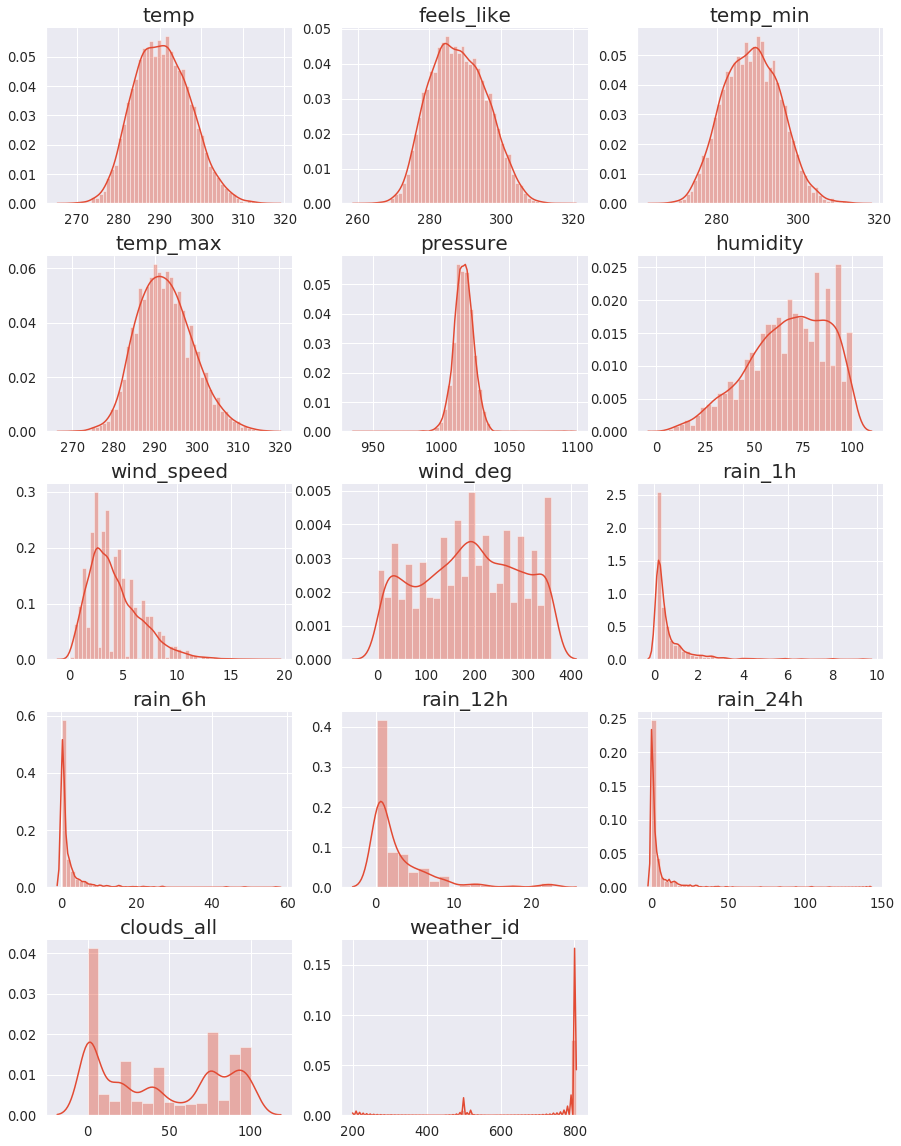

In [52]:
viz.Plot_MultiFaceted_Distributions(distData[colsNumc])

In [53]:
isCatgNotNull = distData[colsCatg].isnull().sum() < distData.shape[0]
catgNotNull = isCatgNotNull.index[isCatgNotNull].values

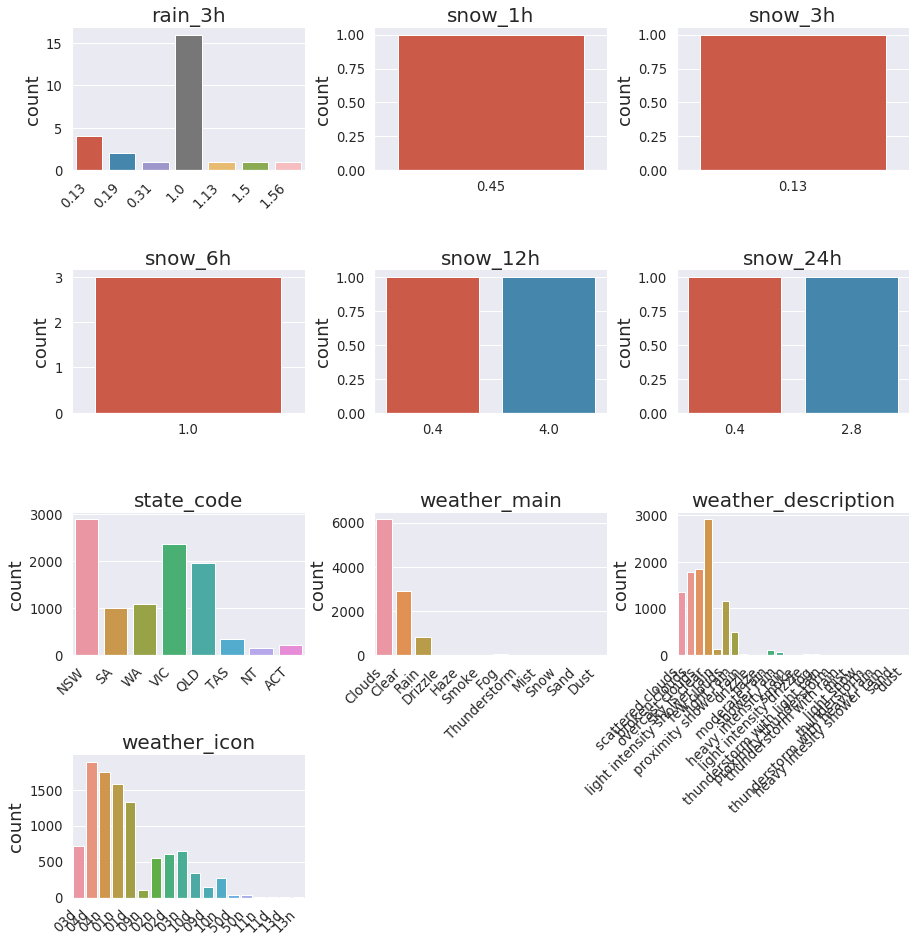

In [54]:
viz.Plot_MultiFaceted_Counts(distData[catgNotNull])

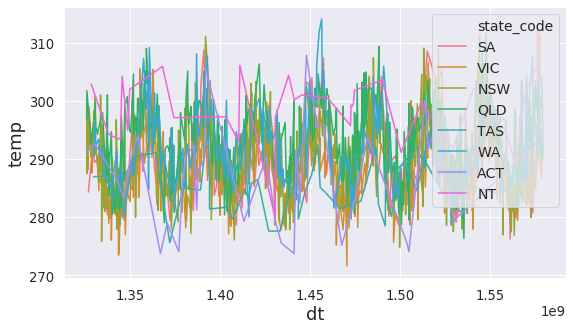

In [55]:
# Temperature over time
sns.lineplot(x='dt', y='temp', hue='state_code', data=plotData.sample(2000))
plt.show()

## Copy data to S3

In [77]:
file_weather = 'weather_20200207.parquet'
path_s3 = f's3://data-preprod-redshift-exports/Joe/a02_weather/{file_weather}'
path_local = f'{path_data}/{file_weather}'

rawData.to_parquet(path_local, index=False)

In [ ]:
wxu.Copy_Gsutil(path_local, path_s3)